In this notebook we test FFNN for Honeycomb Heisenberg model

Honeycomb 3x3 has 18 spins and is numerically solvable. We test for 3x3 and then try to approximate for 5x5 honeycomb, which has 50 spins

In [2]:
import netket as nk
import jax.numpy as jnp
import jax
import numpy as np
import json
import matplotlib.pyplot as plt
from time import time
from pathlib import Path
from Hamiltonians import Heisenberg
from Models import FeedForwardNeuralNetwork
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

In [3]:
cpu = jax.devices('cpu')[0]
gpu = jax.devices('gpu')[0]
cpu, gpu

(CpuDevice(id=0), CudaDevice(id=0))

In [3]:
read = False
res_path = Path('./Simulations/5-FFNNComparison')
image_path = Path('./images/5-FFNNComparison')
extent = [3, 3]
alpha_list = [(0.3,), (1,), (2,), (1, 1), (2, 2), (2, 2, 2)]
Sz = 0
lr = 0.05
ds = 0.1
n_iter = 500
n_samples = 8 * 128 * 6

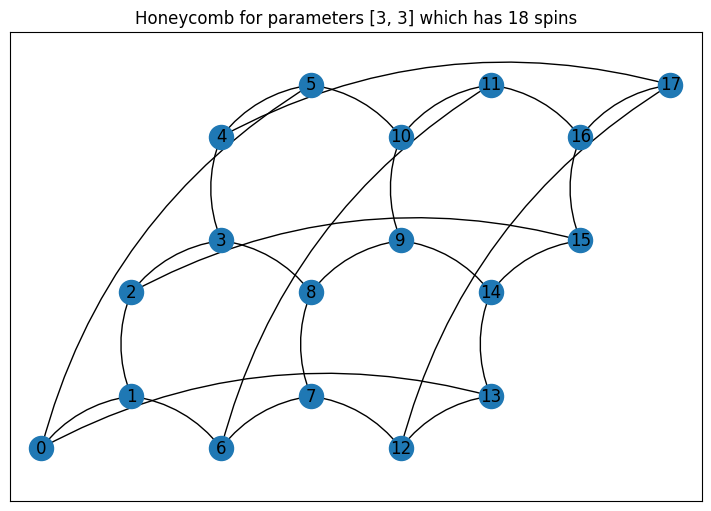

In [4]:
figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(7, 5))
honey = nk.graph.Honeycomb(extent=extent, pbc=True)
honey.draw(ax=axes)
axes.set(xticks=[], yticks=[], 
         title=f'Honeycomb for parameters {extent} which has {honey.n_nodes} spins');

In [5]:
hilbert = nk.hilbert.Spin(s=1/2, total_sz=Sz, N=honey.n_nodes)
hamiltonian = nk.operator.Heisenberg(hilbert=hilbert, graph=honey, J=1)
eval_gs = nk.exact.lanczos_ed(hamiltonian, k=1, compute_eigenvectors=False)[0]
eval_gs

-40.3886633460195

Comparing different Feed Forward Neural Networks

In [6]:
ffnn_results0 = []
times = []
for alpha in alpha_list:
    honey_path = f'{res_path}/HeisenbergHoneycomb/ffnnN{honey.n_nodes}' \
                 f'alpha{list(alpha)}{"Sz0" if Sz == 0 else ""}lr{lr}niter{n_iter}'
    if not read:
        honey = nk.graph.Honeycomb(extent=extent, pbc=True)
        hilbert = nk.hilbert.Spin(s=1/2, total_sz=Sz, N=honey.n_nodes)
        hamiltonian = nk.operator.Heisenberg(hilbert=hilbert, graph=honey, J=1)
        sampler = nk.sampler.MetropolisExchange(hilbert=hilbert, graph=honey)
        optimizer = nk.optimizer.Sgd(learning_rate=lr)
        sr = nk.optimizer.SR(diag_shift=ds)
        ffnn = FeedForwardNeuralNetwork(layer_alpha=alpha)
        vstate = nk.vqs.MCState(sampler, ffnn, n_samples=n_samples)
        gs = nk.VMC(hamiltonian=hamiltonian, optimizer=optimizer, 
                    preconditioner=sr, variational_state=vstate)
    
        start = time()
        gs.run(n_iter=n_iter, out=honey_path)
        print(f'Time: {(t := time()-start):.3f} seconds')
        with open(f'{honey_path}.log', 'r') as res:
            ffnn_result = json.load(res)
        ffnn_result['time'] = t
        if eval_gs is not None:
            ffnn_result['gs'] = float(eval_gs)
        with open(f'{honey_path}.log', 'w') as f:
            json.dump(ffnn_result, f)
        ffnn_results0.append(ffnn_result)
    else:
        with open(f'{honey_path}.log') as res:
            ffnn_results0.append(json.load(f))

  0%|          | 0/500 [00:00<?, ?it/s]

Time: 313.525 seconds


  0%|          | 0/500 [00:00<?, ?it/s]

Time: 324.348 seconds


  0%|          | 0/500 [00:00<?, ?it/s]

Time: 361.444 seconds


  0%|          | 0/500 [00:00<?, ?it/s]

Time: 417.764 seconds


  0%|          | 0/500 [00:00<?, ?it/s]

Time: 511.018 seconds


  0%|          | 0/500 [00:00<?, ?it/s]

Time: 591.794 seconds


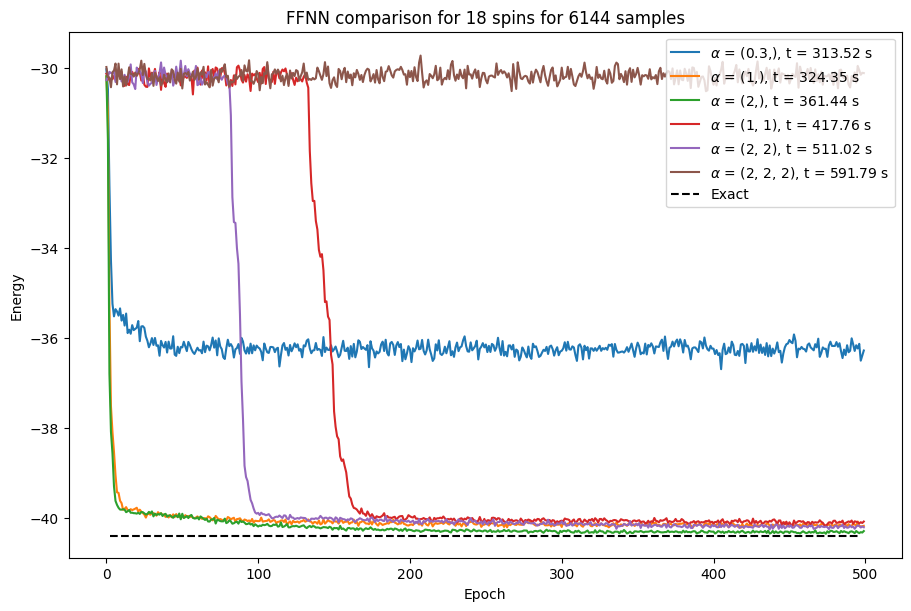

In [7]:
figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(9, 6))
for ffnn_res, alpha in zip(ffnn_results0, alpha_list):
    axes.plot(ffnn_res['Energy']['iters'], ffnn_res['Energy']['Mean'],
              label=f'$\\alpha$ = {alpha}, t = {ffnn_res["time"]:.2f} s')
if eval_gs is not None:
    axes.axhline(y=eval_gs, xmin=0.05, xmax=0.95, 
                 color='black', linestyle='--', label='Exact')
axes.set(xlabel='Epoch', ylabel='Energy', 
         title=f'FFNN comparison for {honey.n_nodes} spins for {n_samples} samples')
axes.legend()
axes.grid()
figure.savefig(image_path / f'Honeycomb{extent}Iter{n_iter}Samples{n_samples}.png');

Testing again for 50 spins and 1000 epochs

In [8]:
read = False
extent = [5, 5]
eval_gs = None
Sz = 0
lr = 0.05
ds = 0.1
n_iter = 500
n_samples = 8 * 128 * 6

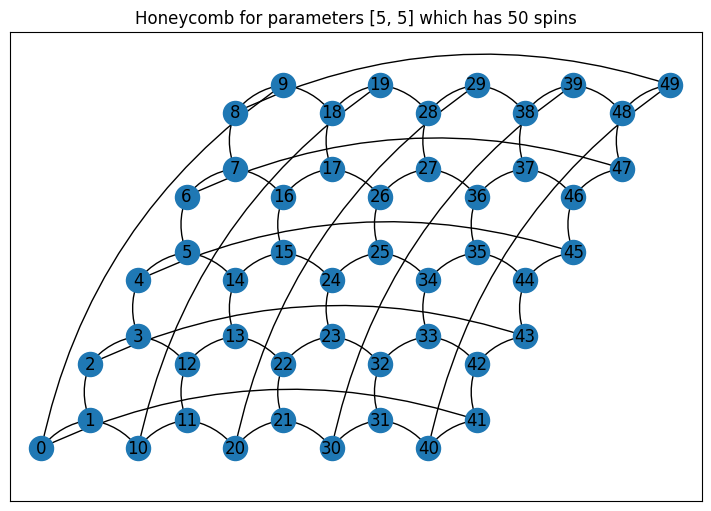

In [9]:
figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(7, 5))
honey = nk.graph.Honeycomb(extent=extent, pbc=True)
honey.draw(ax=axes)
axes.set(xticks=[], yticks=[], 
         title=f'Honeycomb for parameters {extent} which has {honey.n_nodes} spins');

In [10]:
ffnn_results1 = []
for alpha in alpha_list:
    honey_path = f'{res_path}/HeisenbergHoneycomb/ffnnN{honey.n_nodes}' \
                 f'alpha{list(alpha)}{"Sz0" if Sz == 0 else ""}lr{lr}niter{n_iter}'
    if not read:
        honey = nk.graph.Honeycomb(extent=extent, pbc=True)
        hilbert = nk.hilbert.Spin(s=1/2, total_sz=Sz, N=honey.n_nodes)
        hamiltonian = nk.operator.Heisenberg(hilbert=hilbert, graph=honey, J=1)
        sampler = nk.sampler.MetropolisExchange(hilbert=hilbert, graph=honey)
        optimizer = nk.optimizer.Sgd(learning_rate=lr)
        sr = nk.optimizer.SR(diag_shift=ds)
        ffnn = FeedForwardNeuralNetwork(layer_alpha=alpha, param_dtype=jnp.float32)
        vstate = nk.vqs.MCState(sampler, ffnn, n_samples=n_samples)
        gs = nk.VMC(hamiltonian=hamiltonian, optimizer=optimizer, 
                    preconditioner=sr, variational_state=vstate)
    
        start = time()
        gs.run(n_iter=n_iter, out=honey_path)
        print(f'Time: {(t := time()-start):.3f} seconds')
        with open(f'{honey_path}.log', 'r') as res:
            ffnn_result = json.load(res)
        ffnn_result['time'] = t
        if eval_gs is not None:
            ffnn_result['gs'] = float(eval_gs)
        with open(f'{honey_path}.log', 'w') as f:
            json.dump(ffnn_result, f)
        ffnn_results1.append(ffnn_result)
    else:
        with open(f'{honey_path}.log', 'r') as res:
            ffnn_results1.append(json.load(res))

  0%|          | 0/500 [00:00<?, ?it/s]

Time: 983.712 seconds


  0%|          | 0/500 [00:00<?, ?it/s]

Time: 1124.713 seconds


  0%|          | 0/500 [00:00<?, ?it/s]

Time: 1166.359 seconds


  0%|          | 0/500 [00:00<?, ?it/s]

Time: 1479.455 seconds


  0%|          | 0/500 [00:00<?, ?it/s]

Time: 2092.286 seconds


  0%|          | 0/500 [00:00<?, ?it/s]

Time: 2534.752 seconds


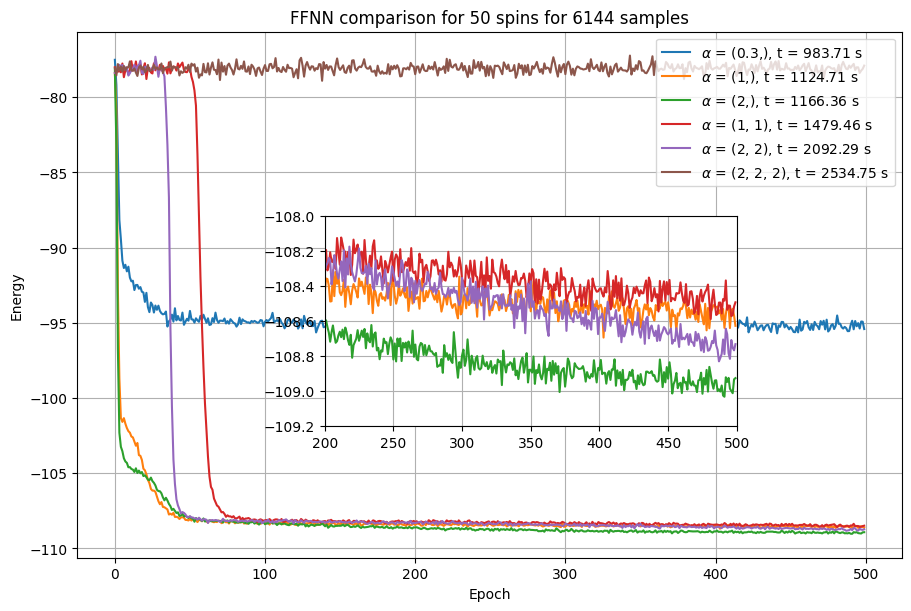

In [22]:
figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(9, 6))
inset_ax = axes.inset_axes([0.3, 0.25, 0.5, 0.4])
for ffnn_res, alpha in zip(ffnn_results1, alpha_list):
    axes.plot(ffnn_res['Energy']['iters'], ffnn_res['Energy']['Mean'],
              label=f'$\\alpha$ = {alpha}, t = {ffnn_res["time"]:.2f} s')
    inset_ax.plot(ffnn_res['Energy']['iters'], ffnn_res['Energy']['Mean'])
if eval_gs is not None:
    axes.axhline(y=eval_gs, xmin=0.05, xmax=0.95, 
                 color='black', linestyle='--', label='Exact')
axes.set(xlabel='Epoch', ylabel='Energy', #ylim=[-110, -87],
         title=f'FFNN comparison for {honey.n_nodes} spins for {n_samples} samples')
axes.legend()
axes.grid()
inset_ax.set(xlim=[200, 500], ylim=[-109.2, -108.0])
inset_ax.grid()
figure.savefig(image_path / f'Honeycomb{extent}Iter{n_iter}Samples{n_samples}.png');

As we can see, the best performance isn't straightforward. For smaller number of spins the best performing model was $\alpha = 2$, but for 50 spins better option was two-layer model $\alpha = (1, 1)$